In [27]:
#based on https://github.com/yuanqqq/SIN
from flax import linen as nn
import numpy as np
from typing import Any, Callable, Optional, Tuple, Type, List
from jax import lax, random, numpy as jnp
import einops
import optax



def get_edgeloss(image:jnp.ndarray,mask:jnp.ndarray,axis:int,edge_loss_multiplier:float):
    """
    in order to also force the supervoxels to keep to the strong edges
    we can add edge loss that will be comparing a directional gradient of the mask
    and image, hovewer the importance of the loss should be proportional to the strength of the edges
    so we can simply get first the l2 loss element wise than scale it by the image gradient
    """
    image_gradient=jnp.power(jnp.gradient(image,4,axis=axis),2)
    mask_gradient=jnp.power(jnp.gradient(mask,4,axis=axis),2)
    #loss=optax.softmax_cross_entropy(image_gradient,mask_gradient)
    image_grad= jnp.power((image_gradient-jnp.min(image_gradient.flatten()) )/jnp.max(image_gradient.flatten()),2)
    # mask_gradient=(mask_gradient-jnp.min(mask_gradient.flatten()) )/jnp.max(mask_gradient.flatten())

    loss=optax.l2_loss(image_gradient,mask_gradient)
    # loss= jnp.multiply(loss,image_grad)*edge_loss_multiplier
    return jnp.mean(loss.flatten())*edge_loss_multiplier
    

In [28]:
image= jnp.array(np.random.random((32,32)))
mask = np.ones_like(image)
mask[:,-5:]=0
mask[:,0:5]=0
mask[0:5,:]=0
mask[-5:,:]=0
mask=jnp.array(mask)
axis=0
edge_loss_multiplier=10000.0

randomm=get_edgeloss(image,mask,axis,edge_loss_multiplier)
image=np.array(image)
image_prim=image.copy()
mulll=20
# image[:,-5:]=image_prim[:,-5:]/mulll
# image[:,0:5]=image_prim[:,0:5]/mulll
# image[0:5,:]=image_prim[0:5,:]/mulll
# image[-5:,:]=image_prim[-5:,:]/mulll


image[:,-5:]=image_prim[:,-5:]*mulll
image[:,0:5]=image_prim[:,0:5]*mulll
image[0:5,:]=image_prim[0:5,:]*mulll
image[-5:,:]=image_prim[-5:,:]*mulll


image=jnp.array(image)
with_edge=get_edgeloss(image,mask,axis,edge_loss_multiplier)
print(f"randomm {randomm} with_edge {with_edge}")


randomm 0.21312935650348663 with_edge 19849.115234375


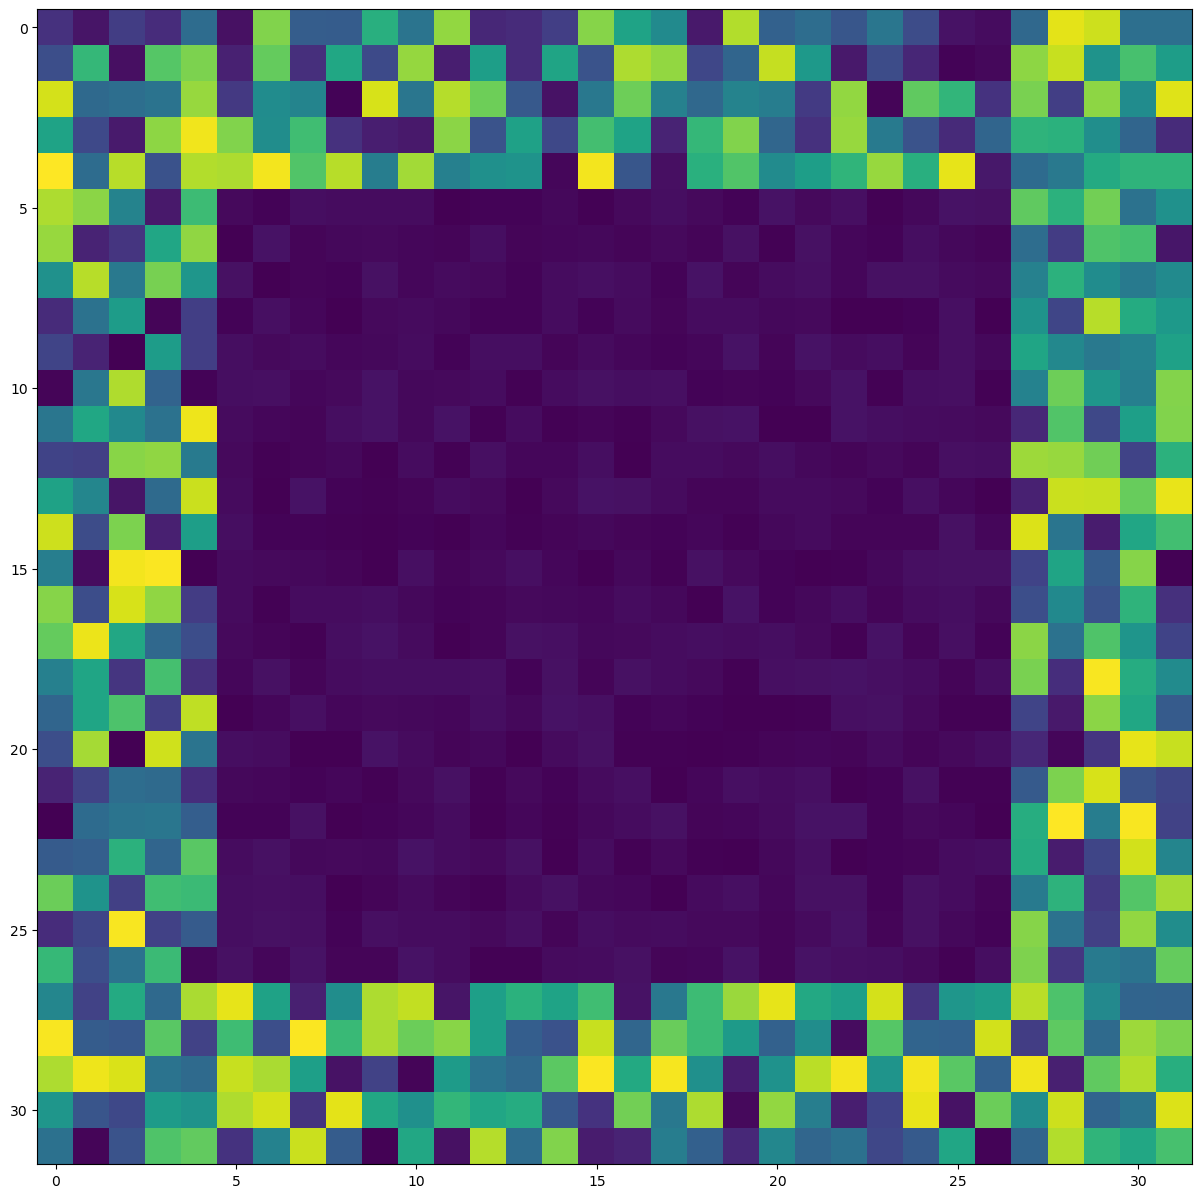

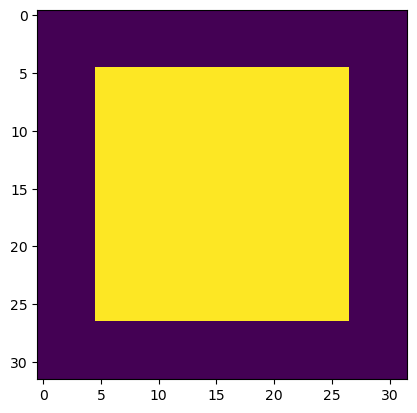

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import jax

plt.figure(figsize=(15, 15))
# plt.set_cmap("gray")
plt.imshow(image)
plt.show()
plt.imshow(mask)
plt.show()

In [30]:
# krowa normalize gradients by dividing by maximum do the same with features ...

# Feature loss

In [31]:
def translate_mask_in_axis(mask:jnp.ndarray, axis:int,is_forward:int,translation_val:int,mask_shape:Tuple[int]):
    """
    translates the mask in a given axis 
    also forward or backward it perform it by padding and
    take
    value of translation is described by translation_val
    """
    mask_orig=mask.copy()
    mask= jnp.take(mask, indices=jnp.arange(translation_val*(1-is_forward),mask_shape[axis]-translation_val* is_forward),axis=axis )
    to_pad=np.array([[0,0],[0,0]])
    is_back=1-is_forward
    to_pad[axis,is_back]=translation_val
    mask= jnp.pad(mask,to_pad)
    return jnp.multiply(mask,mask_orig)

def get_image_features(image:jnp.ndarray,mask:jnp.ndarray):
    """
    given image and a mask will calculate the set of image features
    that will return as a vector  
    """
    masked_image= jnp.multiply(image,mask)
    meann= jnp.sum(masked_image.flatten())/jnp.sum(mask.flatten())
    varr= jnp.power( jnp.multiply((masked_image-meann),mask  ),2)
    varr=jnp.sum(varr.flatten())/jnp.sum(mask.flatten())
    return jnp.array([meann, varr])

def get_translated_mask_variance(image:jnp.ndarray
                                 ,mask:jnp.ndarray
                                 ,translation_val:int
                                 ,mask_shape:Tuple[int]
                                 ,feature_loss_multiplier:float):
    """ 
    we will make a translation of the mask in all directions and check wether image features change
    generally the same supervoxel should have the same image features in all of its subregions
    so we want the variance here to be small 
    """
    features=jnp.stack([
        get_image_features(image,translate_mask_in_axis(mask,0,0,translation_val,mask_shape)),
        get_image_features(image,translate_mask_in_axis(mask,0,1,translation_val,mask_shape)),
        get_image_features(image,translate_mask_in_axis(mask,1,0,translation_val,mask_shape)),
        get_image_features(image,translate_mask_in_axis(mask,1,1,translation_val,mask_shape))
              ])
    maxes= jnp.max(features,axis=0)
    features=features/maxes
    print(f"features \n {features} \n *****")
    feature_variance=jnp.var(features,axis=0)*feature_loss_multiplier
    # print(f"features {features} feature_variance {feature_variance}")
    return jnp.mean(feature_variance)


In [32]:
import numpyro
import numpyro.distributions as dist
mu_0=0
mu_1=200
var_0=5
var_1=900


rng_key = random.PRNGKey(3)
image= numpyro.sample('mu', dist.Normal(mu_0,var_0), sample_shape=(32,32),rng_key=rng_key)
numm=5
image_b= numpyro.sample('mu2', dist.Normal(mu_1,var_1), sample_shape=(32,32),rng_key=rng_key)
image= np.array(image)
image[:,-numm:]=image_b[:,-numm:]*mulll
image[:,0:numm]=image_b[:,0:numm]*mulll
image[0:numm,:]=image_b[0:numm,:]*mulll
image[-numm:,:]=image_b[-numm:,:]*mulll
image=jnp.array(image)

mask = np.ones_like(image)
mask_num_a=5
mask[:,-mask_num_a:]=0
mask[:,0:mask_num_a]=0
mask[0:mask_num_a,:]=0
mask[-mask_num_a:,:]=0
mask=jnp.array(mask)
mask_aaa=mask.copy()
feature_loss_multiplier=10.0
translation_val=6
mask_shape=(32,32)

randomm=get_translated_mask_variance(image
                                 ,mask_aaa
                                 ,translation_val
                                 ,mask_shape
                                 ,feature_loss_multiplier)
image=np.array(image)
image_prim=image.copy()
# image[:,-5:]=image_prim[:,-5:]/mulll
# image[:,0:5]=image_prim[:,0:5]/mulll
# image[0:5,:]=image_prim[0:5,:]/mulll
# image[-5:,:]=image_prim[-5:,:]/mulll

translation_mask=4
translated_mask=jnp.pad(mask,((translation_mask,0),(translation_mask,0)))
translated_mask=translated_mask[:-translation_mask ,: -translation_mask]


with_edge=get_translated_mask_variance(image
                                 ,translated_mask
                                 ,translation_val
                                 ,mask_shape
                                 ,feature_loss_multiplier)


print(f"orig {randomm} translated {with_edge}")


features 
 [[0.4951963  1.        ]
 [0.8560182  0.9657002 ]
 [1.         0.98585916]
 [0.84185404 0.9955489 ]] 
 *****
features 
 [[0.4912852  0.46101284]
 [1.         0.9575747 ]
 [0.64227194 0.39875922]
 [0.81454086 1.        ]] 
 *****
orig 0.17309992015361786 translated 0.5608264207839966


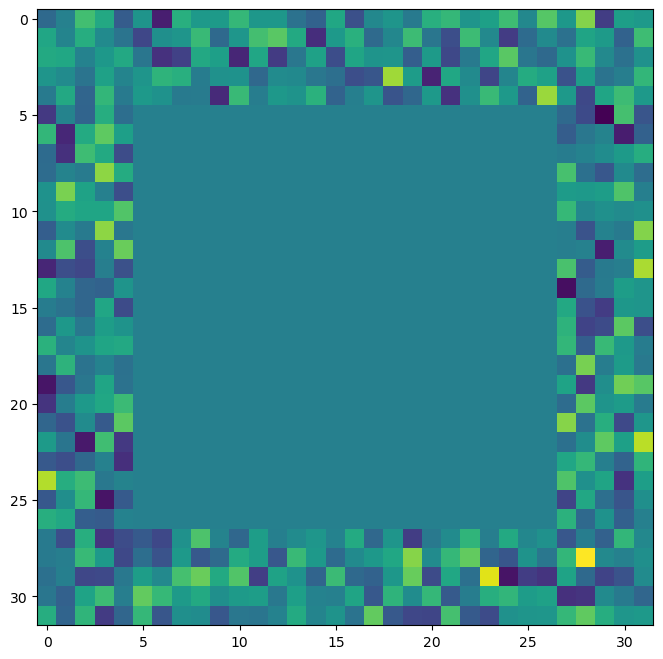

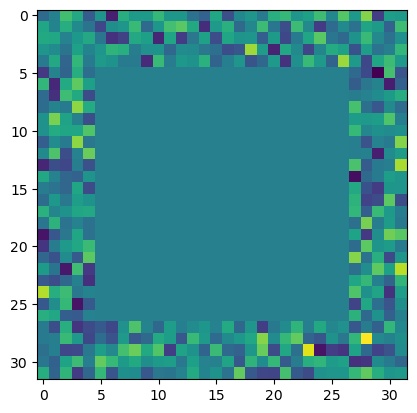

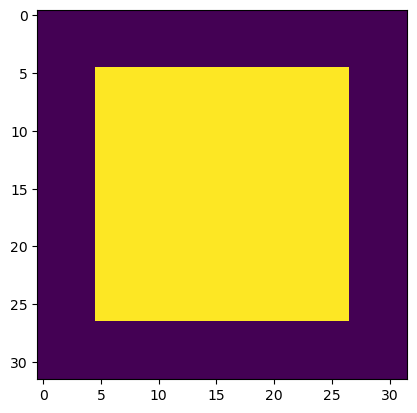

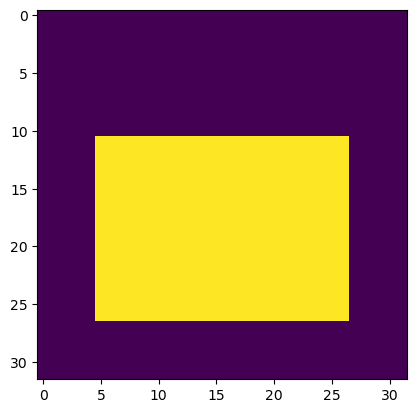

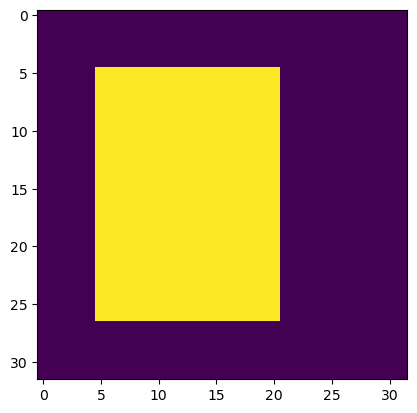

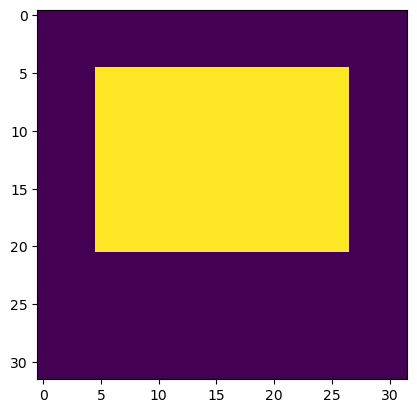

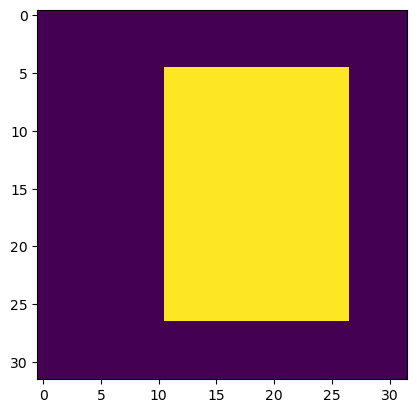

In [33]:
plt.figure(figsize=(8, 8))
# plt.set_cmap("gray")
plt.imshow(image)
plt.show()
plt.imshow(image_prim)
plt.show()

plt.imshow(mask_aaa)
# plt.show()
# plt.imshow(translated_mask)
plt.show()
plt.imshow(translate_mask_in_axis(mask,0,1,translation_val,mask_shape))
plt.show()
plt.imshow(translate_mask_in_axis(mask,1,0,translation_val,mask_shape))
plt.show()
plt.imshow(translate_mask_in_axis(mask,0,0,translation_val,mask_shape))
plt.show()
plt.imshow(translate_mask_in_axis(mask,1,1,translation_val,mask_shape))
plt.show()


# consistency loss

In [34]:
import seaborn as sns
# sns.heatmap(glue)
def check_mask_consistency(mask_old,mask_new,axis):
    """
    as we are simulating interpolation we want to check weather the new mask behaves as
    the interpolation of old one - so the new entries of the mask should be similar to the entries up ro down axis 
    so basically we want to get a similar values when we go 1 up and one down the axis
    However we have the special case of the edge, 
    in order to detect the edge and treat it separately we will use image gradients in a given direction
    """
    #we pad becouse on the border we have high gradient - and we want to ignore it
    old_mask_padded= jnp.pad(mask_old,((1,1),(1,1)))
    #as some entries will be negative oter positive we square it
    grad = jnp.power(jnp.gradient(old_mask_padded,axis=axis),2)
    #removing unnecessery padding
    grad= grad[1:-1,1:-1]
    #we multiply to make sure that we will get values above 1 - we will relu later so exact values do not matter
    #we have here the old mask dilatated in place of edges in a chosen axis
    sum_grads= grad*5+mask_old*5
    print("sum gradsss")
    sns.heatmap(sum_grads)
    plt.show()
    #now we subtract from the new mask old one so all positive value that remain are in the spots 
    #that should not be present
    for_loss=mask_new-sum_grads
    print("aaa for_loss")
    sns.heatmap(for_loss)
    plt.show()
    #we get rid of negative values - as those should not contribute to loss
    for_loss=nn.relu(for_loss)
    print("relu for_loss")
    sns.heatmap(for_loss)
    plt.show()
    #we sum all of the positive entries - the bigger the sum the worse is the consistency
    now we need also to get in opposite side so we assume shrinking instead of enlarging and check weather a new version agrees with a shrinked version ...


    return jnp.mean(for_loss.flatten())

SyntaxError: invalid syntax (1566971342.py, line 35)

In [ ]:
import numpyro
import numpyro.distributions as dist
mu_0=0
mu_1=2
var_0=5
var_1=9


rng_key = random.PRNGKey(3)
image= numpyro.sample('mu', dist.Normal(mu_0,var_0), sample_shape=(32,32),rng_key=rng_key)
image_b= numpyro.sample('mu2', dist.Normal(mu_1,var_1), sample_shape=(32,32),rng_key=rng_key)

axis=0
rearrange_to_intertwine_einops='f h w-> (h f) w'
# rearrange_to_intertwine_einops='f h w -> h (w f)'

mask_old=jnp.ones((16,16))
mask_new=jnp.ones((20,20))
mask_old=jnp.pad(mask_old,((8,8),(8,8)))
mask_new=jnp.pad(mask_new,((6,6),(6,6)))




mask_combined=einops.rearrange([mask_new,mask_old],rearrange_to_intertwine_einops)
minn=check_mask_consistency(mask_old,mask_new,axis)





print(f"minn {minn} ")

In [ ]:
plt.imshow(mask_new)
plt.show()
plt.imshow(mask_old)
plt.show()
plt.imshow(mask_combined)
plt.show()

In [54]:
import numpy as np
a=np.array([0.0,0.0])
b=np.array([0.0,0.0])

np.dot(a+0.0001,b+0.0001) 



2e-08

In [43]:
import numpy as np
a=np.array([0.1,0.9])
b=np.array([0.9,0.1])
pii= np.pi/2
def angle(a):    
    return np.array([np.cos(a[0]*pii ), np.sin(a[1]*pii )])

c=angle(a)-angle(b)
np.round(c,2)


array([0.83, 0.83])

In [75]:
pii=np.pi/2
aa=np.sin(0.1*pii)
bb=np.sin(0.1*pii)

aa_2=np.sin(0.9*pii)
bb_2=np.sin(0.9*pii)
# aa=0.1
# bb=0.9

# (np.sin(aa)+np.cos(aa))*(np.sin(bb)+np.cos(bb))
aa*bb+(1-aa_2)*(1-bb_2)

0.024623318809724546

In [72]:
aa*bb

0.024471741852423214

In [73]:
(1-aa)*(1-bb)

0.7116028117719615

In [90]:
def my_round(a):
    pii=np.pi/2
    return np.sin(a*pii)**2

my_round(my_round(my_round(0.65)))

0.9280350264432299

In [ ]:
idea do a weighted mean getting into account that some entries are not 0;1 ...

In [135]:
# image= np.array([0.9,0.8,0.8])
# mask=np.array([0.9,0.7,0.8])

image= np.array([0.9,0.8,0.8,1.0])
mask=np.array([0.9,0.7,0.8,0.00001])

masked_image=np.multiply(image,mask)
def masked_mean(image,mask):
    image_sum= np.sum(masked_image)
    return image_sum/np.sum(mask)

mean=masked_mean(image,mask)

np.sum((np.multiply(masked_image-mean,mask))**2)/np.sum(mask)
# np.sum((image-np.mean(image))**2)/len(image)

# np.var(image)

0.026379061142646886

In [ ]:
np.multiply(image,mask)